# Reference
- Pythonでデータ分析：PyStanで線形回帰モデル
 - http://tekenuko.hatenablog.com/entry/2017/10/14/150405

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import sklearn
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

Boston = load_boston()
X = Boston.data
y = Boston.target
# 学習用・検証用にデータを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [4]:
import pystan

# データ（辞書型）
dat = {'N': X_train.shape[0], 'M': X_train.shape[1], 'X': X_train, 'y': y_train}

# Stanコード
model = """
    data {
        int<lower=0> N;
        int<lower=0>M;
        matrix[N, M] X;
        vector[N] y;
    }
    parameters { 
        real beta_0;
        vector[M] beta;
        real<lower=0> sigma;
    }
    model { 
        for (i in 1:N)
            y[i] ~ normal(beta_0 + dot_product(X[i] , beta), sigma);
    }
"""

In [6]:
%time stm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0456a22b1cde927056973d34c99a2678 NOW.


CPU times: user 1.7 s, sys: 208 ms, total: 1.91 s
Wall time: 1min 56s


In [7]:
n_itr = 5000
n_warmup = 1000
chains = 2

# サンプリングの実行
%time fit = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)

CPU times: user 213 ms, sys: 71.5 ms, total: 285 ms
Wall time: 3min 3s


In [8]:
fit

Inference for Stan model: anon_model_0456a22b1cde927056973d34c99a2678.
2 chains, each with iter=5000; warmup=1000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_0    36.15     0.1   5.74  24.86  32.39  36.15  39.98  47.37   3421    1.0
beta[1]    -0.1  4.2e-4   0.04  -0.18  -0.13   -0.1  -0.07  -0.02   8780    1.0
beta[2]    0.06  1.7e-4   0.02   0.03   0.05   0.06   0.07   0.09   7390    1.0
beta[3]  9.6e-3  8.0e-4   0.07  -0.12  -0.03 9.5e-3   0.05   0.14   6979    1.0
beta[4]    2.05  9.4e-3   0.96   0.17   1.41   2.04   2.71   3.97  10612    1.0
beta[5]  -16.84    0.05   4.23 -25.09 -19.71 -16.82 -14.01   -8.6   6230    1.0
beta[6]    3.72  6.9e-3   0.46   2.82   3.42   3.72   4.03   4.61   4432    1.0
beta[7]  9.9e-3  1.9e-4   0.01  -0.02-2.1e-4 9.9e-3   0.02   0.04   6511    1.0
beta[8]   -1.68  3.2e-3   0.24  -2.16  -1.84  -1.68  -1.53  -1.21   5479    1.0
beta[9]    

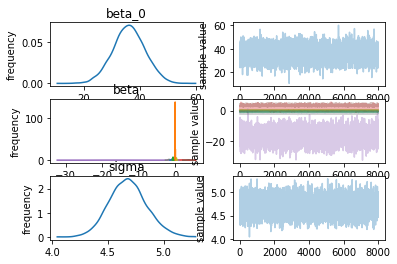

In [9]:
fit.plot()

/Users/aoi/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


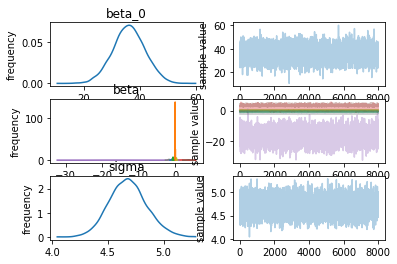

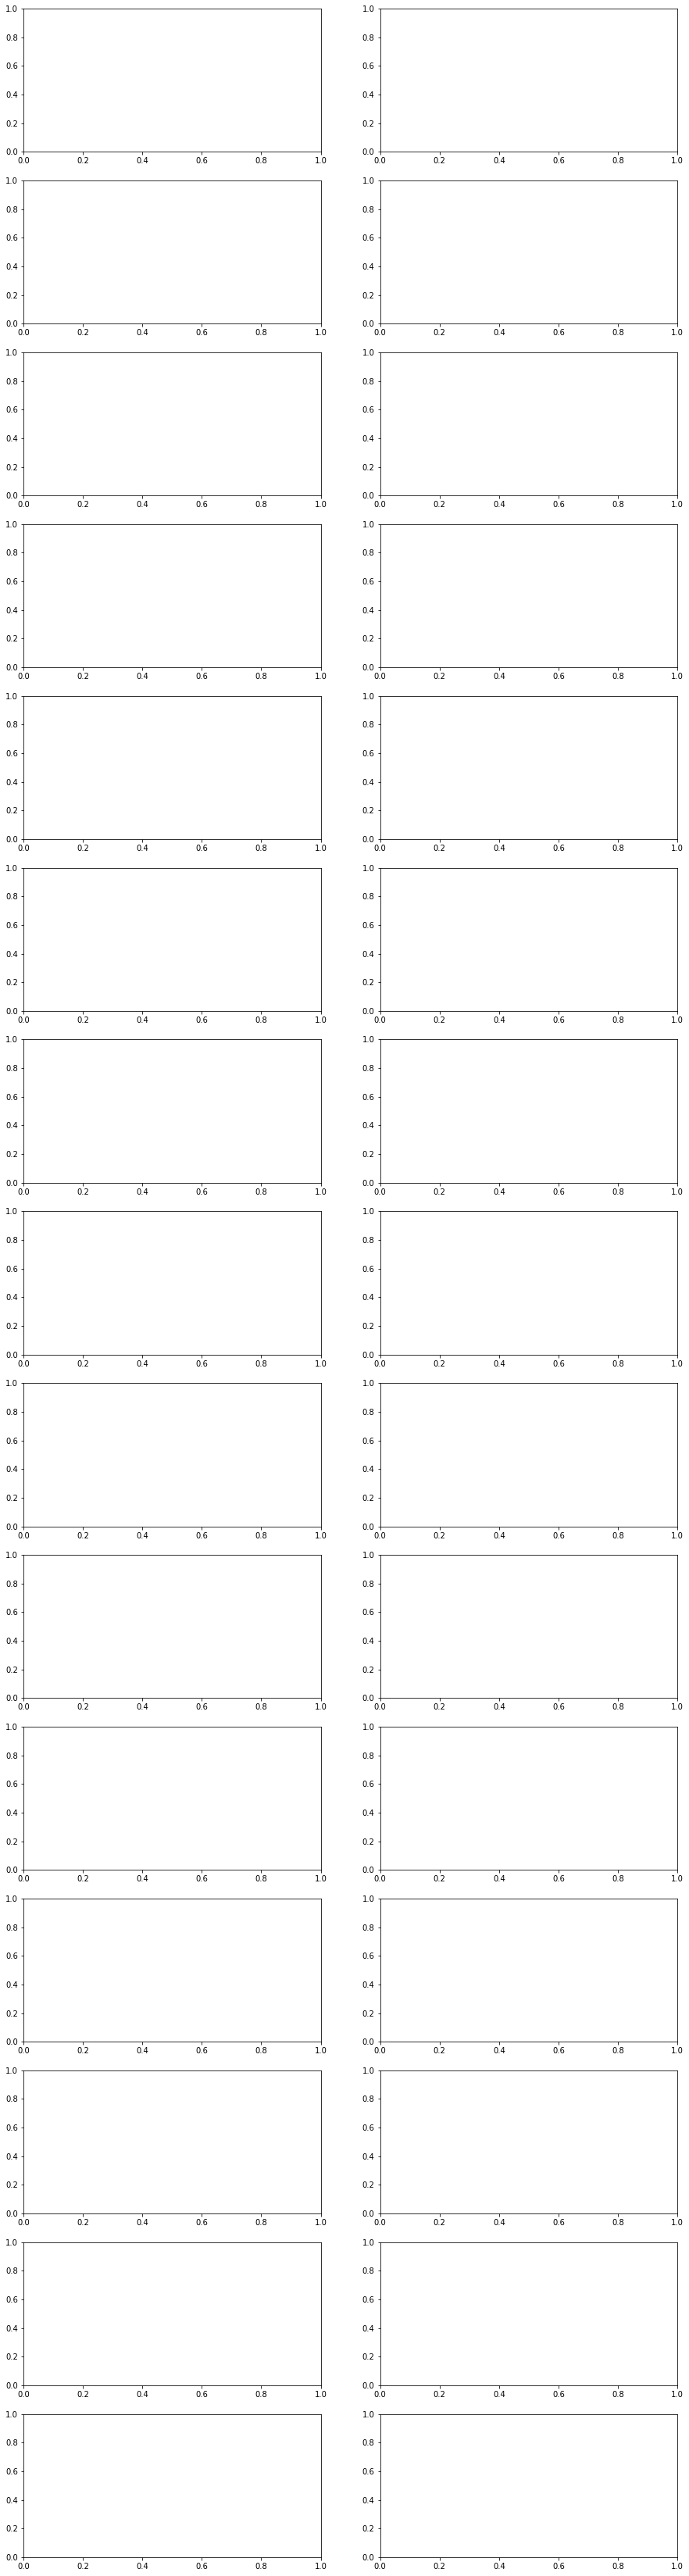

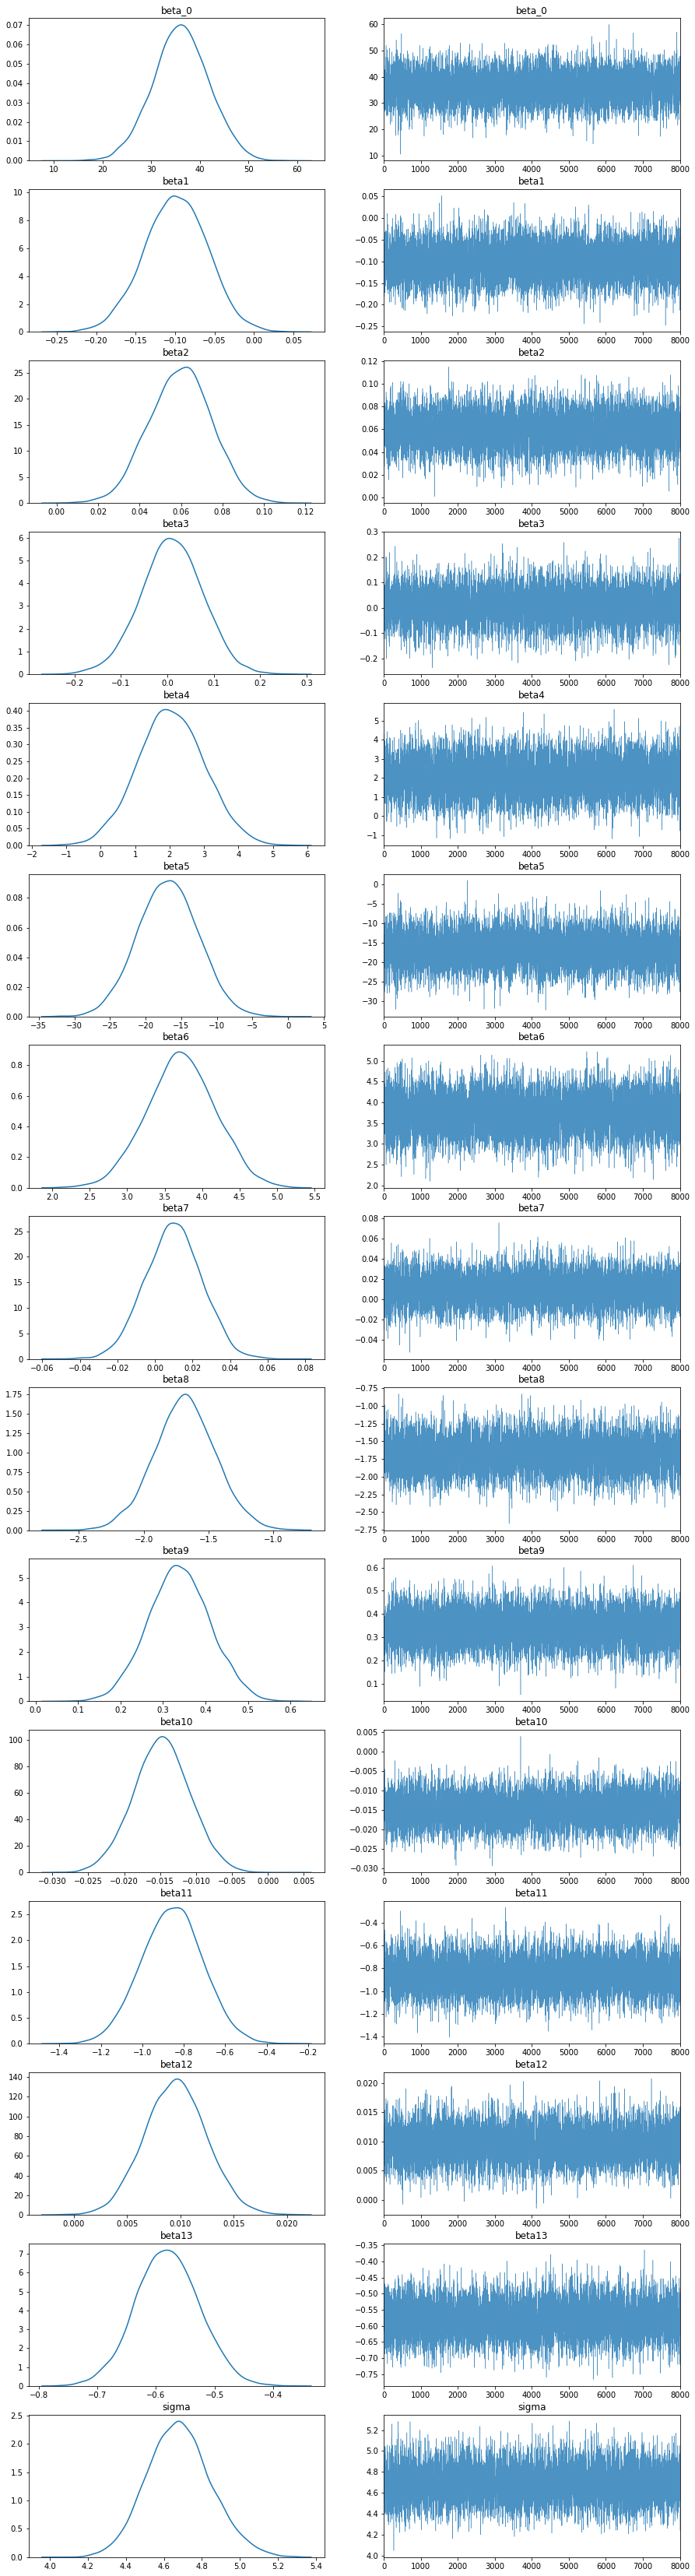

In [17]:
# サンプル列を抽出
la  = fit.extract(permuted=True)
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])

# プロット
f, axes = plt.subplots(n_param, 2, figsize=(15, 4*n_param))
cnt = 0
for name in names:
    dat = la[name]
    if dat.ndim == 2:
        for j in range(dat.shape[1]):
            d = dat[:,j]
            sns.distplot(d, hist=False, ax=axes[cnt, 0])
            sns.tsplot(d,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
            cnt += 1
    else:
        # Intercept
        sns.distplot(dat, hist=False, ax=axes[cnt, 0])
        sns.tsplot(dat,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
        cnt += 1

name_list = []
for name in names:
    dat = la[name]
    if la[name].ndim == 2:
        for i in range(dat.shape[1]):
            name_list.append("{}{}".format(name,i+1))
    else:
        name_list.append(name)

for i in range(2):
    for j, t in enumerate(name_list):
        axes[j, i].set_title(t)
plt.show()

In [12]:
# 平均値算出
beta0 = la['beta_0'].mean()
beta = la['beta'].mean(axis = 0)
# 予測値算出
y_pred_train = (X_train * beta).sum(axis = 1) + beta0
y_pred_test = (X_test * beta).sum(axis = 1) + beta0
# 学習用、検証用データに関してMSEとR^2を出力
from sklearn.metrics import mean_squared_error, r2_score
print('MSE Train: %.2f, MSE Test: %.2f' % (mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)))
print('R^2 Train: %.2f, R^2 Test: %.2f' % (r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)))

MSE Train: 21.02, MSE Test: 26.52
R^2 Train: 0.76, R^2 Test: 0.65
